# Synthetic Question Answering
Work on Babi Dataset from Facebook Research.

In [2]:
import pickle
import numpy as np

In [3]:
with open('train_qa.txt', "rb") as fp:    #Unpickling
    train_data = pickle.load(fp)

In [4]:
with open('test_qa.txt', "rb") as fp:     #Unpickling
    test_data = pickle.load(fp)

### Exploring the Format of the Data

In [5]:
train_type = type(train_data)
print(f"Train type: {train_type}")
test_type = type(test_data)
print(f"Test type: {test_type}")
train_len = len(train_data)
print(f"Train length: {train_len}")
test_len = len(test_data)
print(f"Test length: {test_len}")

Train type: <class 'list'>
Test type: <class 'list'>
Train length: 10000
Test length: 1000


In [6]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [7]:
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [8]:
" ".join(train_data[0][1])

'Is Sandra in the hallway ?'

In [9]:
train_data[0][2]

'no'

#### We see that our data has some Stories/Statements, based on those we have some Questions and an Answer to those questions in "yes" or "no." 
We will call our stories/statements as a set of inputs 'X', questions as query 'q' and the output/answer to those as 'a'.

### Creating a Vocabulary of All Words

In [10]:
vocab = set()
full_data = test_data + train_data

In [11]:
for story, question, answer in full_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [12]:
vocab.add('no')
vocab.add('yes')

In [13]:
# vocab

In [14]:
max_story_len = max([len(data[0]) for data in full_data])
max_story_len

156

In [15]:
max_query_len = max([len(data[1]) for data in full_data])
max_query_len

6

In [16]:
#add an extra space to hold a 0 for Keras' pad sequences
vocab_size = len(vocab) + 1

### Tokenization

In [17]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [19]:
#tokens assigned to each unique from our vocab(vocabulary)
print(tokenizer.word_index)

{'mary': 1, 'sandra': 2, '?': 3, 'bathroom': 4, 'office': 5, 'picked': 6, 'moved': 7, '.': 8, 'went': 9, 'journeyed': 10, 'hallway': 11, 'is': 12, 'apple': 13, 'yes': 14, 'put': 15, 'in': 16, 'daniel': 17, 'discarded': 18, 'milk': 19, 'took': 20, 'kitchen': 21, 'down': 22, 'garden': 23, 'travelled': 24, 'back': 25, 'dropped': 26, 'john': 27, 'bedroom': 28, 'to': 29, 'the': 30, 'there': 31, 'got': 32, 'no': 33, 'grabbed': 34, 'left': 35, 'up': 36, 'football': 37}


### Vectorization

In [20]:
def vectorize_data(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_query_len=max_query_len):
    '''
    INPUT:
    
    data: our data consisting Statements, Questions and Answers
    word_index: word index dictionary from tokenizer (which we created in the tokenization phase)
    max_story_len: the length of the longest group of input statements
    maax_question_len: length of longest question
    
    
    OUTPUT:
    
    returns a tuple (X,Xq,Y) of padded sequences.
    '''
    #Stories
    X = []
    #Query/Questions
    Xq = []
    #Correct Answer
    Y = []
    
    for story, query, answer in data:
        
        #Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        #Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        #Now grab the answers, index 0 is reserved so +1
        y = np.zeros(len(word_index) + 1)
        #Use numpy logic to create this assignment
        y[word_index[answer]] = 1
        
        #Append the gathered values to their respective lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    #Finally, pad the sequences based on their max length so that RNN can be trained on uniformly long sequences
    
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_query_len), np.array(Y))

In [21]:
train_inputs, train_queries, train_answers = vectorize_data(train_data)

In [22]:
test_inputs, test_queries, test_answers = vectorize_data(test_data)

For train and test both we will have as depicted below:

In [23]:
train_inputs

array([[ 0,  0,  0, ..., 30, 28,  8],
       [ 0,  0,  0, ..., 30, 11,  8],
       [ 0,  0,  0, ..., 30,  4,  8],
       ...,
       [ 0,  0,  0, ..., 30, 28,  8],
       [ 0,  0,  0, ..., 19, 31,  8],
       [ 0,  0,  0, ..., 13, 31,  8]])

The inputs are an array of lists having padded sequences containing the word indexes corresponding to the word in that particular story.

In [24]:
train_queries

array([[12,  2, 16, 30, 11,  3],
       [12, 17, 16, 30,  4,  3],
       [12, 17, 16, 30,  5,  3],
       ...,
       [12,  2, 16, 30, 11,  3],
       [12,  1, 16, 30, 21,  3],
       [12,  1, 16, 30, 28,  3]])

Queries will be arrays of list containing for each item of the array i.e a query, the word indexes of the words present in that query.

In [25]:
train_answers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

And finally answers will also be an array of list where either the yes or no word_index will be marked according to the answer.

### Building the Model

In [26]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

#### Defining Placeholders for Inputs
Since we have two inputs (stories and questions), so we need to use placeholders. `Input()` is used to instantiate a Keras tensor.

In [27]:
#Placeholder shape=(max_story_len, batch_size) 
#We haven't defined the batch size yet.
input_sequence = Input((max_story_len,))
question = Input((max_query_len,))

#### Building Encoders
*Input Encoder m*

In [81]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=256))
input_encoder_m.add(Dropout(0.4))
# This encoder will output:
# (samples, story_maxlen, embedding_dim)

*Input Encoder c*

In [82]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_query_len))
input_encoder_c.add(Dropout(0.4))
# output: (samples, story_maxlen, query_maxlen)

*Question Encoder*

In [83]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=256,input_length=max_query_len))
question_encoder.add(Dropout(0.4))
# output: (samples, query_maxlen, embedding_dim)

#### Encode the sequences

In [84]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [85]:
#Computing the match between first input vector seq and the query
match = dot([input_encoded_m,question_encoded], axes=(2,2))
match = Activation('softmax')(match)
#match is a probability vector over the inputs

In [86]:
#Adding the match matrix with second input vector sequence
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [87]:
#Concatenating the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [88]:
#Reduce with RNN (LSTM)
answer = LSTM(32)(answer)

In [89]:
#Performing regularization again
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)     # (samples, vocab_size)

In [90]:
#output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

#build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      multiple             9728        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 6, 256)       9728        input_2[0][0]                    
____________________________________________________________________________________________

In [92]:
history = model.fit([train_inputs, train_queries], train_answers, 
                    batch_size = 32, epochs = 200,
                    validation_data=([test_inputs, test_queries], test_answers))

Train on 10000 samples, validate on 1000 samples
Epoch 1/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.9197 - accuracy: 0.4987 - val_loss: 0.6954 - val_accuracy: 0.4970
Epoch 2/200
10000/10000 [==============================] - 8s 805us/step - loss: 0.7030 - accuracy: 0.4929 - val_loss: 0.6944 - val_accuracy: 0.4970
Epoch 3/200
10000/10000 [==============================] - 8s 823us/step - loss: 0.6954 - accuracy: 0.5022 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 4/200
10000/10000 [==============================] - 10s 981us/step - loss: 0.6956 - accuracy: 0.4921 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 5/200
10000/10000 [==============================] - 10s 986us/step - loss: 0.6945 - accuracy: 0.4976 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 6/200
10000/10000 [==============================] - 9s 886us/step - loss: 0.6942 - accuracy: 0.5030 - val_loss: 0.6987 - val_accuracy: 0.4970
Epoch 7/200
10000/10000 [==============================

10000/10000 [==============================] - 9s 852us/step - loss: 0.1302 - accuracy: 0.9502 - val_loss: 0.3466 - val_accuracy: 0.8970
Epoch 110/200
10000/10000 [==============================] - 9s 874us/step - loss: 0.1304 - accuracy: 0.9521 - val_loss: 0.3138 - val_accuracy: 0.8930
Epoch 111/200
10000/10000 [==============================] - 9s 870us/step - loss: 0.1327 - accuracy: 0.9489 - val_loss: 0.3360 - val_accuracy: 0.8850
Epoch 112/200
10000/10000 [==============================] - 9s 881us/step - loss: 0.1281 - accuracy: 0.9494 - val_loss: 0.3626 - val_accuracy: 0.8860
Epoch 113/200
10000/10000 [==============================] - 9s 888us/step - loss: 0.1248 - accuracy: 0.9547 - val_loss: 0.3606 - val_accuracy: 0.8860
Epoch 114/200
10000/10000 [==============================] - 9s 894us/step - loss: 0.1266 - accuracy: 0.9513 - val_loss: 0.3319 - val_accuracy: 0.8880
Epoch 115/200
10000/10000 [==============================] - 8s 842us/step - loss: 0.1300 - accuracy: 0.9538

### Evaluating the Model
#### Plotting out the Training History

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


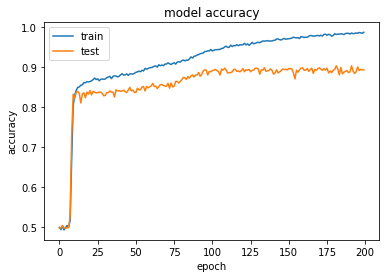

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
pred_results = model.predict(([test_inputs, test_queries]))

In [118]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [119]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [120]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [121]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9951676


*Let's try testing with our own story*

In [122]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_question = "Is the football in the kitchen ?"
mydata = [(my_story.split(),my_question.split(),'no')]

In [123]:
my_story,my_ques,my_ans = vectorize_data(mydata)

In [124]:
pred_results = model.predict(([ my_story, my_ques]))

In [125]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9951676


### END